##Neste notebook será feita a estimação de parâmetros para o sistema **Acetona-Metanol** no modelo de Wilson. Essa estimação será feita minimizando os desvios dos resultados de temperatura do ponto de bolha e composição da fase gasosa calculados pelo modelo de Wilson e aqueles de dados experimentais obtidos pelo Dortmund Data Bank, dados esses disponíveis em:

###http://www.ddbst.com/en/EED/VLE/VLE%20Acetone%3BMethanol.php

##Aqui vou usar o Data set 586.

In [ ]:
# Preparando kernel
import numpy as np
import pandas as pd
!pip3 install pickle5
import pickle5 as pickl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Montando o Google drive
from google.colab import drive
drive.mount('/content/drive')
# Para ler/carregar
path = '/content/drive/MyDrive/Operações 3/'
#path = '/content/drive/MyDrive/Classroom/OpUnit3_files/OU3_Python/'
with open(path + 'databank_properties.pickle', 'rb') as handle:
    dados, all_units = pickl.load(handle)
print(dados.shape)
# Incluindo uma pasta do drive (mounted) no path do COLAB
import sys
sys.path.append(path)
# Carregamento das funções úteis
from OU3_funcoes_uteis_v05_2 import *

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(468, 31)


In [ ]:
# Para procurar o 'num' de um determinado componente pelo nome
dados[dados.name.str.contains('acetone', case = False)]

,num,name,molar_mass,fusion_point,boiling_point,critical_temp,critical_pressure,critical_volume,zc,acentric_factor,...,pvap_a,pvap_b,pvap_c,temp_max_pvap,temp_min_pvap,pvap_h_a,pvap_h_b,pvap_h_c,pvap_h_d,delta_h_vap_bp
145,122,ACETONE,58.08,178.2,329.4,508.1,46.4,209.0,0.232,0.309,...,16.6513,2940.46,-35.93,350.0,241.0,NaN,NaN,NaN,NaN,6960.0


In [ ]:
# Seleção dos componentes presentes no sistema
lista_componentes = [122, 62]
nc = len(lista_componentes)
nc

2

In [ ]:
dados[dados['num'].isin(lista_componentes)][['num','name']]

,num,name
145,122,ACETONE
296,62,METHANOL


In [ ]:
# Verificando os pontos de ebulição de nossos componentes
T_eb_comp = dados[dados['num'].isin(lista_componentes)]['boiling_point']
T_eb_comp = T_eb_comp.tolist()
T_eb_comp

[329.4, 337.8]

In [ ]:
# Valores do a_W - Tabela 12.5, p. 354 SVNA
# acetona = 1
# metanol = 2
nc = 2
a_W = np.zeros((nc,nc))
# acetona e metanol

a_W[0][1] = -161.88
a_W[1][0] = 583.11

a_W

array([[   0.  , -161.88],
       [ 583.11,    0.  ]])

In [ ]:
#Cálculando o volume molar
V_m = f_Vol_molar_db(lista_componentes, dados)
V_m

array([73.51898734, 40.50821745])

In [ ]:
#Pressão de equilíbrio usada nos dados do Dortmund:
P_eq = 101.33*(760.00/101.325) #mmHg
P_eq

760.0375030841352

In [ ]:
#Definindo a função que calcula a temperatura do ponto de bolha
#
def f_calc_T_Pb_nid_Wilson_01_db(z, P_eq, a_W, V_m, lista_componentes, dados):
  ''' Algoritmo de BOL_T descrito na figura 14.3 p.409 do SVNA
  '''
  nc = z.shape[0]
  resp = f_calculo_PbPo_db('T', P_eq, z, lista_componentes, dados)
  T_pb_ideal = resp[0]
  T_pb = T_pb_ideal
  x_eq = z
  y_eq = f_sol_RR_flash_db(z, P_eq, T_pb, lista_componentes, dados)['y_eq']
  K_comp = f_K_Raoult_mod_Wilson_01_db(T_pb, P_eq, x_eq, y_eq, a_W, V_m, 
                                       lista_componentes, dados)
  # Eq.14.8 do SVNA
  y_eq_novo = K_comp * x_eq
  phi_comp = f_phi_gen(y_eq_novo, T_pb, P_eq)
  gama_comp = f_gama_Wilson(x_eq, T_pb, a_W, V_m)
  # Componente de referência
  jj = 1                                               #Aqui mudei o jj de 2 para 1 porque estava dando erro de índice
  # Eq. 14.13 do SVNA
  fator = x_eq*gama_comp/phi_comp
  Pvap_comp = f_Pvap_Antoine_vetor_db(T_pb, lista_componentes, dados)
  razao = Pvap_comp/Pvap_comp[jj]
  somat = fator @ razao
  Pvap_novo = P_eq / somat
  # Eq. 14.15 do SVNA
  T_pb_novo = f_Teq_Antoine_db(Pvap_novo, lista_componentes[jj], dados)[0]
  erro_T = T_pb_novo - T_pb
  # Tolerância para convergência
  epsilon = 1.0e-3
  #
  T_pb = T_pb_novo
  y_eq = y_eq_novo
  k_iter = 1
  n_max_iter = 20
  while ((np.abs(erro_T).mean() > epsilon)&(k_iter < n_max_iter)):
    print(k_iter, np.abs(erro_T).mean())
    K_comp = f_K_Raoult_mod_Wilson_01_db(T_pb, P_eq, x_eq, y_eq, 
                                       a_W, V_m, lista_componentes, dados)
    y_eq_novo = K_comp * x_eq
    phi_comp = f_phi_gen(y_eq_novo, T_pb, P_eq)
    gama_comp = f_gama_Wilson(x_eq, T_pb, a_W, V_m)
    fator = x_eq*gama_comp/phi_comp
    Pvap_comp = f_Pvap_Antoine_vetor_db(T_pb, lista_componentes, dados)
    T_pb_novo = np.zeros((nc,))
    for j in range(0, nc):
      razao = Pvap_comp/Pvap_comp[j]
      somat = fator @ razao
      Pvap_novo = P_eq / somat
      T_pb_novo[j] = f_Teq_Antoine_db(Pvap_novo, lista_componentes[j], dados)[0]
    erro_T = T_pb_novo[jj] - T_pb
    T_pb = T_pb_novo[jj] # T_pb_novo.mean()
    y_eq = y_eq_novo
    k_iter += 1
  #
  return {'T_pb': T_pb, 'y_eq':y_eq, 'erro_T': np.abs(erro_T)}

##Criando um Data frame para receber os dados do Data Set 586 presentes em: http://www.ddbst.com/en/EED/VLE/VLE%20Acetone%3BMethanol.php, citado anteriormente.

In [ ]:
caminho = '/content/drive/MyDrive/PFG_Mateus_Ferreira/Dados_ELV_Acetona_metanol.xlsx'
df = pd.read_excel(caminho)
df.head()

,T [K],x1,y1
0,337.75,0.000,0.000
1,336.65,0.036,0.082
2,335.35,0.081,0.161
3,333.85,0.141,0.251
4,332.55,0.206,0.336


In [ ]:
#adicionando duas colunas com os valores de x2 e y2
df['x2'] = 1 - df['x1']
df['y2'] = 1 - df['y1']
#Reordenando as colunas do Data Frame (apenas por fins estéticos)
df = df[['T [K]', 'x1', 'x2', 'y1', 'y2']]
#
#Visualizando os dados de validação
df

,T [K],x1,x2,y1,y2
0,337.75,0.000,1.000,0.000,1.000
1,336.65,0.036,0.964,0.082,0.918
2,335.35,0.081,0.919,0.161,0.839
3,333.85,0.141,0.859,0.251,0.749
4,332.55,0.206,0.794,0.336,0.664
5,331.25,0.293,0.707,0.423,0.577
6,330.05,0.394,0.606,0.500,0.500
7,329.35,0.513,0.487,0.580,0.420
8,329.05,0.584,0.416,0.639,0.361
9,328.95,0.683,0.317,0.705,0.295


In [ ]:
#Transformando os dados de entrada do que estão no Data Frame em uma lista de listas onde cada lista interna contém os valores de fração molar
# de cada componente

x1 = df['x1'].tolist()
x2 = df['x2'].tolist()
lista_composicoes = np.array(list(zip(x1, x2)))
lista_composicoes

array([[0.   , 1.   ],
       [0.036, 0.964],
       [0.081, 0.919],
       [0.141, 0.859],
       [0.206, 0.794],
       [0.293, 0.707],
       [0.394, 0.606],
       [0.513, 0.487],
       [0.584, 0.416],
       [0.683, 0.317],
       [0.742, 0.258],
       [0.823, 0.177],
       [0.861, 0.139],
       [1.   , 0.   ]])

In [ ]:
#Definindo os parâmetros para inserir na função do cálculo dos resíduos
par = np.array([-161.88, 583.11])
par

array([-161.88,  583.11])

In [ ]:
def f_res_par(par, P_eq, V_m, lista_componentes, dados, df):
  '''
    Entradas:
      df: dataframe com os dados experimentais para a estimação
    Saidas:

  '''

  nc = 2
  a_W = np.zeros((nc, nc))
  #
  a_W[0][1] = par[0]
  a_W[1][0] = par[1]
  #
  composicoes = df[['x1', 'x2']]
  x1 = composicoes['x1'].tolist()
  x2 = composicoes['x2'].tolist()
  z = np.array(list(zip(x1, x2)))
  #
  n_exp = df.shape[0]
  res_T = np.zeros((n_exp,))
  res_y1 = np.zeros((n_exp,))
  res_y2 = np.zeros((n_exp,))
  for k in range(0, n_exp):
    print(k)
    sol_T_pb = f_calc_T_Pb_nid_Wilson_01_db(z[k], P_eq, a_W, V_m, lista_componentes, dados)
    res_T[k] = df.loc[k, 'T [K]'] - sol_T_pb['T_pb']
    res_y1[k] = df.loc[k,'y1'] - sol_T_pb['y_eq'][0]
    res_y2[k] = df.loc[k,'y2'] - sol_T_pb['y_eq'][1]
  #
  res = np.abs(res_T) + np.abs(res_y1) + np.abs(res_y2)
  return (res)

In [ ]:
%%capture
res = f_res_par(par, P_eq, V_m, lista_componentes, dados, df)

In [ ]:
res

array([0.08791638, 0.8755102 , 1.94332928, 3.07789471, 3.92487518,
       4.51473227, 4.77686043, 4.34370134, 3.97899506, 3.15922955,
       2.61177913, 1.87808986, 1.53929869, 0.19965405])

In [ ]:
%%capture
from scipy.optimize import least_squares
# resp = least_squares(f_res_par, par, args=(P_eq, V_m, lista_componentes, dados, df))
resp = least_squares(f_res_par, par, method = 'lm',
                     args=(P_eq, V_m, lista_componentes, dados, df))

In [ ]:
#Obtendo o resutado da otimização, ou seja, os parâmetros ótimos, dados por "x".
resp

     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [ 8.792e-02  2.229e-01 ...  1.550e-01  1.997e-01]
           x: [ 7.039e+02 -2.712e+02]
        cost: 0.21806274692091565
         jac: [[ 0.000e+00  0.000e+00]
               [ 2.640e-03  2.274e-03]
               ...
               [ 3.420e-03  5.096e-03]
               [ 0.000e+00  0.000e+00]]
        grad: [-1.583e-08 -5.972e-09]
  optimality: 1.583282386078376e-08
 active_mask: [0 0]
        nfev: 33
        njev: None

In [ ]:
#parâmetros ótimos do sistema:
par_opt = resp.x
par_opt

array([ 703.93084504, -271.24825215])

##Agora tendo os parâmetros ótimos é só inserí-los na função do cálculo dos resíduos para ver se, de fato, os resíduos ficaram baixos.

In [ ]:
%%capture
res_opt = f_res_par(par_opt, P_eq, V_m, lista_componentes, dados, df)

In [ ]:
res_opt

array([0.08791638, 0.22287299, 0.22275636, 0.11336868, 0.01849664,
       0.12022783, 0.29740704, 0.1776665 , 0.12365364, 0.1037875 ,
       0.20788217, 0.219691  , 0.15503178, 0.19965405])

In [ ]:
#Comparando com os resíduos anteriores:
res

array([0.08791638, 0.8755102 , 1.94332928, 3.07789471, 3.92487518,
       4.51473227, 4.77686043, 4.34370134, 3.97899506, 3.15922955,
       2.61177913, 1.87808986, 1.53929869, 0.19965405])

##Como é possível observar, os resíduos diminuíram muito. Agora, realiza-se a simulção e análise gráfica dos dados experimentais ajustados aos novos parâmetros obtidos

In [ ]:
#Definindo uma função que lê listas de composições de calcula o ponto de bolha da mistur binária e a composição da fase gasosa resultante:
def calcular_ponto_bolha_2_componentes(composicoes, P_eq, a_W, V_m, lista_componentes, dados):
    '''função que calcula a temperatura do ponto de bolha e a composição da fase vapor para uma mistura de componentes e
    armazena os valores em um Data Frame chamado df_resultados.
    z é a lista (ou lista de listas) da composição da fase líquida e P_eq é a pressão de equilíbrio do sistema'''
    resultados = []
    for composicao in composicoes:
        # Chame a função que realiza o cálculo da temperatura do ponto de bolha
        # e da composição da fase vapor com base na composição da mistura e na pressão do sistema
        T_pb_Wilson             = f_calc_T_Pb_nid_Wilson_01_db(composicao, P_eq, a_W, V_m, lista_componentes, dados)['T_pb']
        y1_Wilson               = f_calc_T_Pb_nid_Wilson_01_db(composicao, P_eq, a_W, V_m, lista_componentes, dados)['y_eq'][0]
        y2_Wilson               = f_calc_T_Pb_nid_Wilson_01_db(composicao, P_eq, a_W, V_m, lista_componentes, dados)['y_eq'][1]
        
        # Adicione os resultados em uma lista como tuplas
        resultados.append((composicao, T_pb_Wilson, y1_Wilson, y2_Wilson))
    
    # Criando um DataFrame a partir da lista de resultados
    df_resultados = pd.DataFrame(resultados, columns=["Composição", "T_pb_Wilson", "y1_Wilson", "y2_Wilson"])
    
    return df_resultados

##Após definida a função, é necessário calcular um novo a_W com os parâmetros ótimos para assim testar a função que calcular o ponto de bolha e as composições usando o mesmo:

In [ ]:
#Definindo o a_W ótimo:
a_W_opt = np.zeros((nc,nc))
#
a_W_opt[0][1] = par_opt[0]
a_W_opt[1][0] = par_opt[1]

In [ ]:
#Criando um Data frame com o resultado da estimativa dos valores de y1, y2 e T_pb
%%capture
resultado = calcular_ponto_bolha_2_componentes(lista_composicoes, P_eq, a_W_opt, V_m, lista_componentes, dados)

In [ ]:
resultado

,Composição,T_pb_Wilson,y1_Wilson,y2_Wilson
0,"[0.0, 1.0]",337.662084,0.000000,1.000000
1,"[0.036, 0.964]",336.429069,0.081035,0.918977
2,"[0.081, 0.919]",335.134984,0.164872,0.835132
3,"[0.141, 0.859]",333.744550,0.254968,0.745049
4,"[0.206, 0.794]",332.563330,0.333418,0.666585
5,"[0.293, 0.7070000000000001]",331.361369,0.418575,0.581433
6,"[0.394, 0.606]",330.346031,0.500695,0.499319
7,"[0.513, 0.487]",329.515003,0.586343,0.413680
8,"[0.584, 0.41600000000000004]",329.166945,0.635660,0.364369
9,"[0.683, 0.31699999999999995]",328.848270,0.706047,0.293989


##Agora tendo os valores calculados por Wilson e aqueles experimentais presentes no conjunto de dados faz-se um comparativo entre ambos

#Fazendo uma análise gráfica dos resultados por uma reta de referência em relação a cada uma das variáveis de reposta: $T_{pb}$, $y_1$ e $y_2$


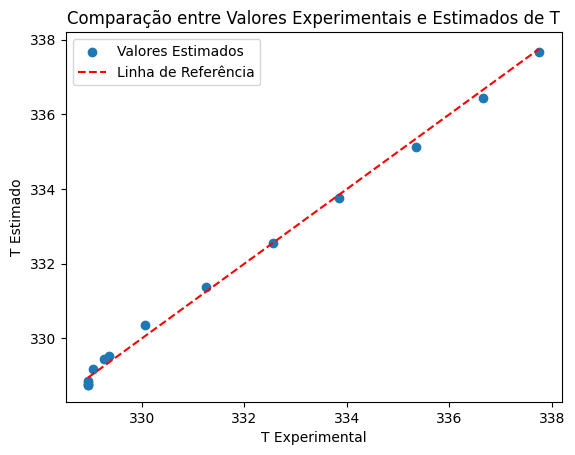

In [ ]:
import matplotlib.pyplot as plt

# Criando um gráfico de dispersão com linha de regressão para T

plt.scatter(df['T [K]'], resultado['T_pb_Wilson'], label='Valores Estimados')
plt.plot([df['T [K]'].min(), df['T [K]'].max()], [df['T [K]'].min(), df['T [K]'].max()], color='red', linestyle='dashed', label='Linha de Referência')
plt.xlabel('T Experimental')
plt.ylabel('T Estimado')
plt.title('Comparação entre Valores Experimentais e Estimados de T')
plt.legend()
plt.show()

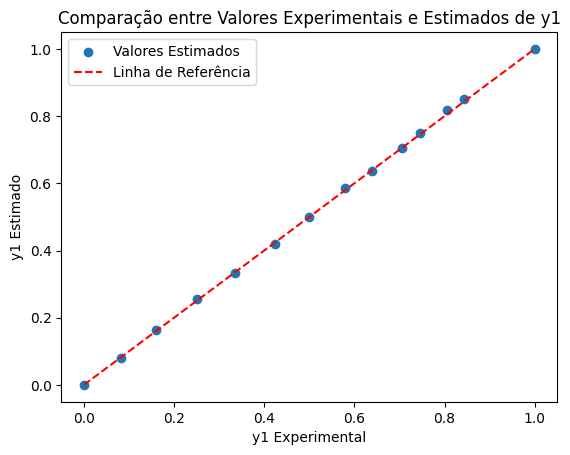

In [ ]:
# Criando um gráfico de dispersão com linha de regressão para y1

plt.scatter(df['y1'], resultado['y1_Wilson'], label='Valores Estimados')
plt.plot([df['y1'].min(), df['y1'].max()], [df['y1'].min(), df['y1'].max()], color='red', linestyle='dashed', label='Linha de Referência')
plt.xlabel('y1 Experimental')
plt.ylabel('y1 Estimado')
plt.title('Comparação entre Valores Experimentais e Estimados de y1')
plt.legend()
plt.show()

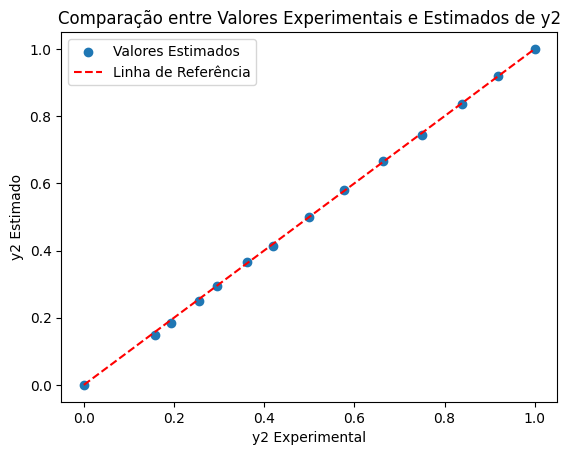

In [ ]:
# Criando um gráfico de dispersão com linha de regressão para y2

plt.scatter(df['y2'], resultado['y2_Wilson'], label='Valores Estimados')
plt.plot([df['y2'].min(), df['y2'].max()], [df['y2'].min(), df['y2'].max()], color='red', linestyle='dashed', label='Linha de Referência')
plt.xlabel('y2 Experimental')
plt.ylabel('y2 Estimado')
plt.title('Comparação entre Valores Experimentais e Estimados de y2')
plt.legend()
plt.show()

##Analisando os desvios e o $R^2$

In [ ]:
# Importando o pacote com as figuras de mérito para avaliar o modelo
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
# Calculando o erro médio absoluto (MAE)
mae_T = mean_absolute_error(df['T [K]'], resultado['T_pb_Wilson'])
mae_y1 = mean_absolute_error(df['y1'], resultado['y1_Wilson'])
mae_y2 = mean_absolute_error(df['y2'], resultado['y2_Wilson'])

# Calculando o erro quadrático médio (MSE)
mse_T = mean_squared_error(df['T [K]'], resultado['T_pb_Wilson'])
mse_y1 = mean_squared_error(df['y1'], resultado['y1_Wilson'])
mse_y2 = mean_squared_error(df['y2'], resultado['y2_Wilson'])

# Calculando a raiz do erro quadrático médio (RMSE)
rmse_T  = np.sqrt(mse_T)
rmse_y1 = np.sqrt(mse_y1)
rmse_y2 = np.sqrt(mse_y2)

# Calculando o coeficiente de determinação (R²)
r2_T  = r2_score(df['T [K]'], resultado['T_pb_Wilson'])
r2_y1 = r2_score(df['y1'], resultado['y1_Wilson'])
r2_y2 = r2_score(df['y2'], resultado['y2_Wilson'])

In [ ]:
#Imprimindo os resultados:
print("Erro Médio Absoluto (MAE) para T: ", mae_T)
print("Erro Médio Absoluto (MAE) para y1: ", mae_y1)
print("Erro Médio Absoluto (MAE) para y2: ", mae_y2)

print("Erro Quadrático Médio (MSE) para T: ", mse_T)
print("Erro Quadrático Médio (MSE) para y1: ", mse_y1)
print("Erro Quadrático Médio (MSE) para y2: ", mse_y2)

print("Raiz do Erro Quadrático Médio (RMSE) para T: ", rmse_T)
print("Raiz do Erro Quadrático Médio (RMSE) para y1: ", rmse_y1)
print("Raiz do Erro Quadrático Médio (RMSE) para y2: ", rmse_y2)

print("Coeficiente de Determinação (R²) para T: ", r2_T)
print("Coeficiente de Determinação (R²) para y1: ", r2_y1)
print("Coeficiente de Determinação (R²) para y2: ", r2_y2)


Erro Médio Absoluto (MAE) para T:  0.15483095552588924
Erro Médio Absoluto (MAE) para y1:  0.00367630315383989
Erro Médio Absoluto (MAE) para y2:  0.003665067306805472
Erro Quadrático Médio (MSE) para T:  0.028758596868797903
Erro Quadrático Médio (MSE) para y1:  2.2923924809633557e-05
Erro Quadrático Médio (MSE) para y2:  2.2773129975713796e-05
Raiz do Erro Quadrático Médio (RMSE) para T:  0.16958359846635496
Raiz do Erro Quadrático Médio (RMSE) para y1:  0.004787893567074519
Raiz do Erro Quadrático Médio (RMSE) para y2:  0.004772120071384813
Coeficiente de Determinação (R²) para T:  0.9969240799629557
Coeficiente de Determinação (R²) para y1:  0.9997376196659358
Coeficiente de Determinação (R²) para y2:  0.999739345618155


##Pelos resultados é possível ver que a estimação dos parâmetros foi bem sucedida e os mesmos ficaram adequados aos dados experimentais.